# The 2015 Calibration Observation Compared to Alan's Coefficients

In this notebook, we try to match Alan's calibration coefficients as closely as possible with `edges_cal`. We show the differences between the two calibrations, and the effect this has on sky data.

Note that there is another version of this notebook in the repo about comparing to the Nature Paper data. We leave that separate because its output is meant to be static with that analysis.

## Imports and Setup

In [1]:
from edges_cal import CalibrationObservation
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import matplotlib.pyplot as plt
from edges_analysis.analysis.calibrate import LabCalibration
from pathlib import Path
from edges_cal import modelling as mdl
from edges_cal import receiver_calibration_func as rcf
from edges_estimate.likelihoods import LinearFG
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.fitting import SemiLinearFit
from yabf.core.samplers import run_map
from edges_cal import s11
import edges_cal as ec
import edges_analysis as ea
import edges_io as eio
import notebook_utils as nutl
import alan_data_utils as utils
from edges_cal.s11 import Receiver
from astropy import units as u
from edges_cal import reflection_coefficient as rc
from edges_cal.tools import FrequencyRange

%matplotlib inline

In [2]:
nutl.setup_mpl()
nutl.print_versions()

Numpy Version:  1.21.2
Astropy Version:  5.0
read_acq Version:  0.4.6.dev14+gd72e4fb.d20220207
edges-io Version:  4.0.0
edges-cal Version:  6.0.0
edges-analysis Version:  4.0.0


## Definition of Calibration Observation

The parameters for this calibration observation were set by email exchange with Alan, and should represent the same set of parameters/data used by him to do his calibration. We also create a `LabCalibration` object, which adds antenna S11 to the receiver calibration. 

The files used here are on the `enterprise` cluster. Note that the final `Calibration` file that is written out (to be used elsewhere in the reproduction of the Nature Paper results) is *not* exactly this observation (see below).

In [15]:
calio = utils.get_calio()
calobs = utils.get_calobs(f_low=40*u.MHz)
labcal = utils.get_labcal(calobs)

## Data Reading

In this notebook, we compare our calibration observation with data directly provided by Alan. Here we read in those data files.

Note that `specal_final_case2.txt` comes from running Alan's C-Code directly. The `loss_file.txt` is output by a *modified version* of Alan's code (none of the workings are modified, it just outputs more intermediate data). The `antenna_s11_file.txt` also comes from the modified version of Alan's code.

In [4]:
# Note that specal_final_case2.txt is equivalent to specal.txt
alan_cal_raw = np.genfromtxt("alan-data/specal_final_case2.txt")

_f = alan_cal_raw[:, 1] * u.MHz
f = calobs.freq.freq

alan_cal_mdl = {
    'lna_s11': lambda f: spline(_f, alan_cal_raw[:, 3])(f) + 1j*spline(_f, alan_cal_raw[:, 4])(f),
    'scale': spline(calobs.freq.normalize(_f), alan_cal_raw[:, 6]),
    'offset': spline(calobs.freq.normalize(_f), alan_cal_raw[:, 8]),
    'tunc': spline(calobs.freq.normalize(_f), alan_cal_raw[:, 10]),
    'tcos': spline(calobs.freq.normalize(_f), alan_cal_raw[:, 12]),
    'tsin': spline(calobs.freq.normalize(_f), alan_cal_raw[:, 14]),
    'weight': spline(_f, alan_cal_raw[:, 16]),
}

# To make it easier to compare to our results, we spline it.
alan_cal = {k: v(f.to_value("MHz") if k in ['lna_s11', 'weight'] else calobs.freq.normalize(f)) for k, v in alan_cal_mdl.items()}
alan_cal['freq'] = f

In [6]:
alan_sky_data = np.genfromtxt("alan-data/spe0.txt")
flg = alan_sky_data[:, 12]>0
alan_sky_data = {
    'freq': alan_sky_data[:, 1][flg],
    't_ant': alan_sky_data[:, 3][flg],
    't_sky': alan_sky_data[:, 6][flg],
}

In [7]:
loss = np.genfromtxt("alan-data/loss_file.txt")
loss_fq = loss[:, 0]
loss_temp = spline(loss_fq, loss[:, 2])(alan_sky_data['freq'])
bmcorr = spline(loss_fq, loss[:, -1])(alan_sky_data['freq'])
loss = spline(loss_fq, loss[:, 1])(alan_sky_data['freq'])

In [8]:
alan_ant_s11 = np.genfromtxt('alan-data/antenna_s11_file.txt')
alan_ant_s11_freq = alan_ant_s11[:, 0]
alan_ant_s11 = spline(alan_ant_s11_freq, alan_ant_s11[:, 1])(f) + 1j*spline(alan_ant_s11_freq, alan_ant_s11[:, 2])(f)

## Compare Receiver Properties

### Receiver S11

First, let's compare the measured and calibrated LNA S11 between the edges-cal observation and Alan's code. To make sure we haven't just used a different run number, we also plot all of the run numbers.

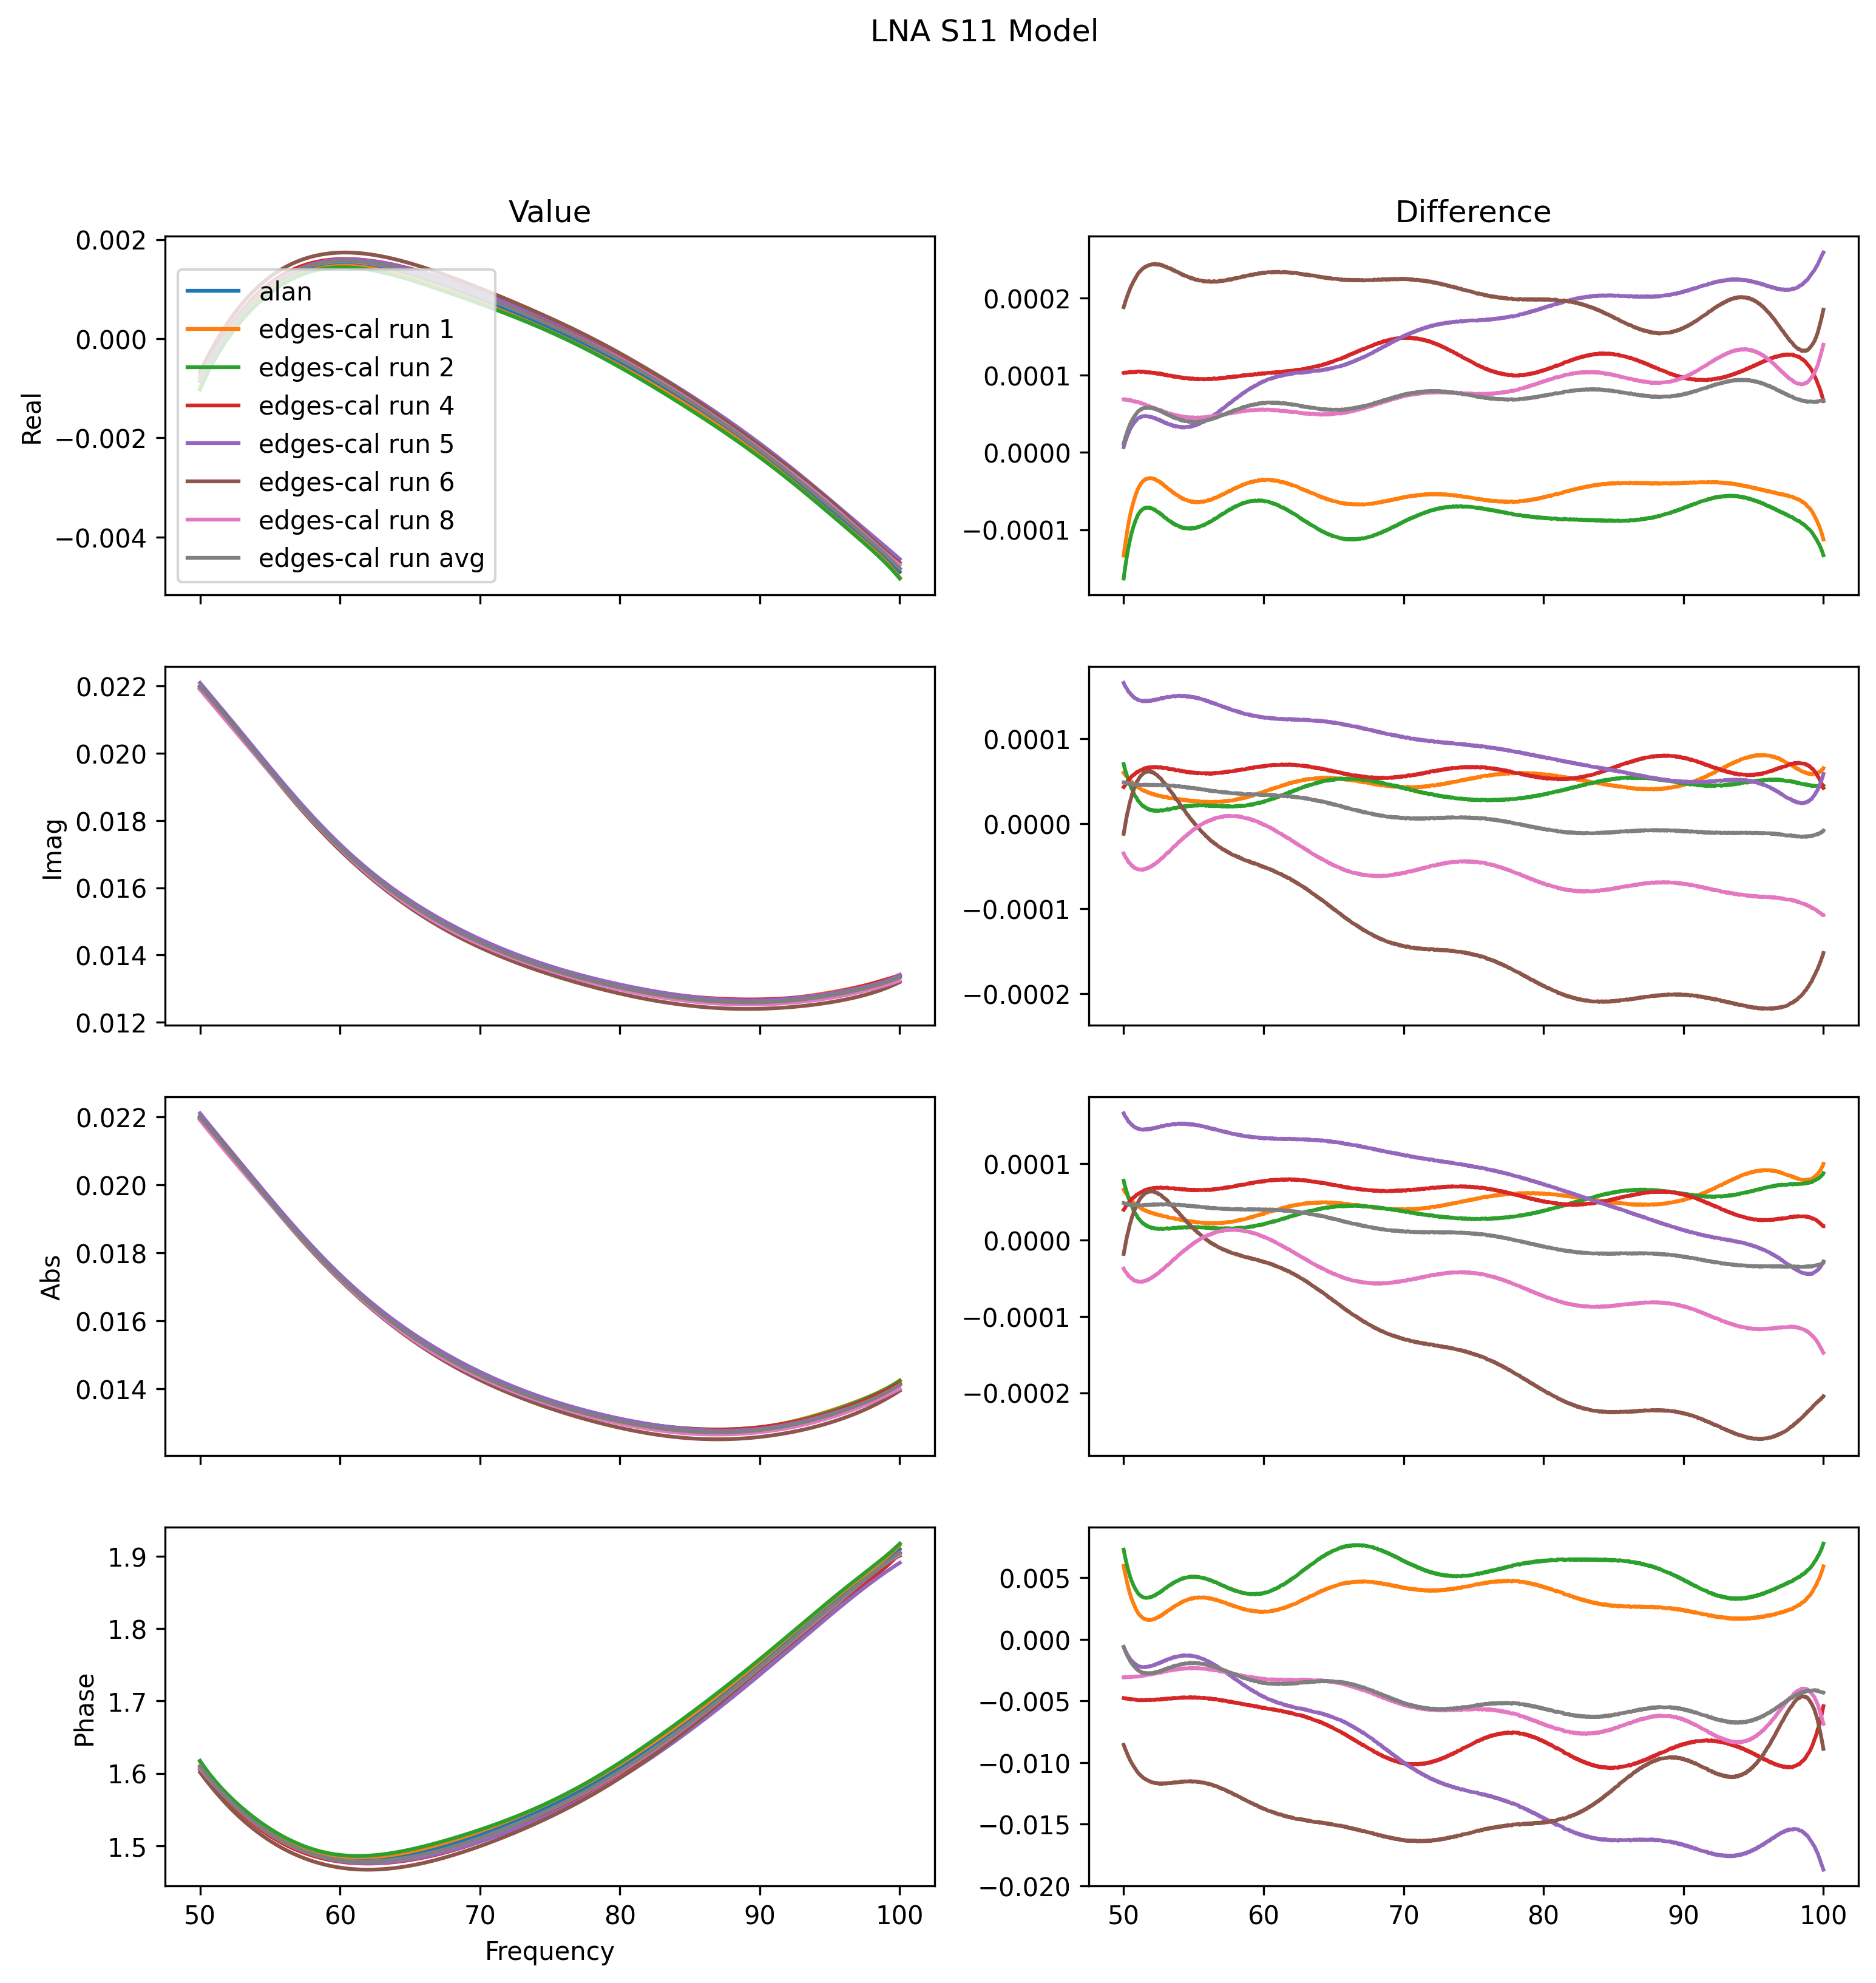

In [18]:
fig, ax = plt.subplots(4, 2, sharex=True, figsize=(12,12))
alan_lna = alan_cal['lna_s11']

ax[0,0].plot(f, np.real(alan_lna), label='alan')
ax[1,0].plot(f, np.imag(alan_lna))
ax[2,0].plot(f, np.abs(alan_lna))
ax[3,0].plot(f, np.angle(alan_lna))

ax[1,0].set_ylabel("Imag")
ax[3,0].set_xlabel("Frequency")
ax[0,0].set_ylabel('Real')
ax[2,0].set_ylabel("Abs")
ax[3,0].set_ylabel("Phase")

rcvs = []
for i, run_num in enumerate([1,2,4,5,6,8, 'avg']):
    if run_num != 'avg':
        rcvio = eio.io.ReceiverReading(calio.s11.path  / f"ReceiverReading{run_num:02}", repeat_num=1)

        rcv = Receiver.from_io(
            rcvio, 
            f_low=40*u.MHz, 
            f_high=calobs.freq.max, 
            n_terms=11, 
            model_type='polynomial',
            calkit=rc.get_calkit(calobs.receiver.metadata['calkit'], match={"offset_delay": 30*u.ps})
        )
        rcvs.append(rcvio)
    else:
        rcv = Receiver.from_io(
            rcvs, 
            f_low=40*u.MHz, 
            f_high=calobs.freq.max, 
            n_terms=11, 
            model_type='polynomial',
            calkit=rc.get_calkit(calobs.receiver.metadata['calkit'], match={"offset_delay": 30*u.ps})
        )
    clb = calobs.clone(receiver=rcv)

    ax[0,0].plot(f, np.real(clb.receiver.s11_model(f)), label='edges-cal run %s'%run_num)
    ax[1,0].plot(f, np.imag(clb.receiver.s11_model(f)))
    ax[2,0].plot(f, np.abs(clb.receiver.s11_model(f)))
    ax[3,0].plot(f, np.angle(clb.receiver.s11_model(f)))
    
    ax[0,1].plot(f, np.real(clb.receiver.s11_model(f)) - np.real(alan_lna), color=f'C{i+1}')
    ax[1,1].plot(f, np.imag(clb.receiver.s11_model(f)) - np.imag(alan_lna), color=f'C{i+1}')
    ax[2,1].plot(f, np.abs(clb.receiver.s11_model(f)) - np.abs(alan_lna), color=f'C{i+1}')
    ax[3,1].plot(f, np.angle(clb.receiver.s11_model(f)) - np.angle(alan_lna), color=f'C{i+1}')
    
fig.suptitle("LNA S11 Model")
ax[0,0].set_title("Value")
ax[0,1].set_title("Difference")

ax[0, 0].legend();

Note that there are definitely differences in the Receiver S11 here. They are minimized when using an average over all run nums. The offset is systematic.

### Antenna S11

We also compare the Antenna S11 here, not because it affects the receiver calibration, but because need it to check the effect of the receiver calibration on the final sky data.

In [10]:
alan_ant_s11_rl = spline(calobs.freq.freq, np.real(alan_ant_s11))
alan_ant_s11_im = spline(calobs.freq.freq, np.imag(alan_ant_s11))

def alan_ant_s11_func(freq):
    return alan_ant_s11_rl(freq) + 1j*alan_ant_s11_im(freq)

Text(0.5, 1.0, 'Antenna S11')

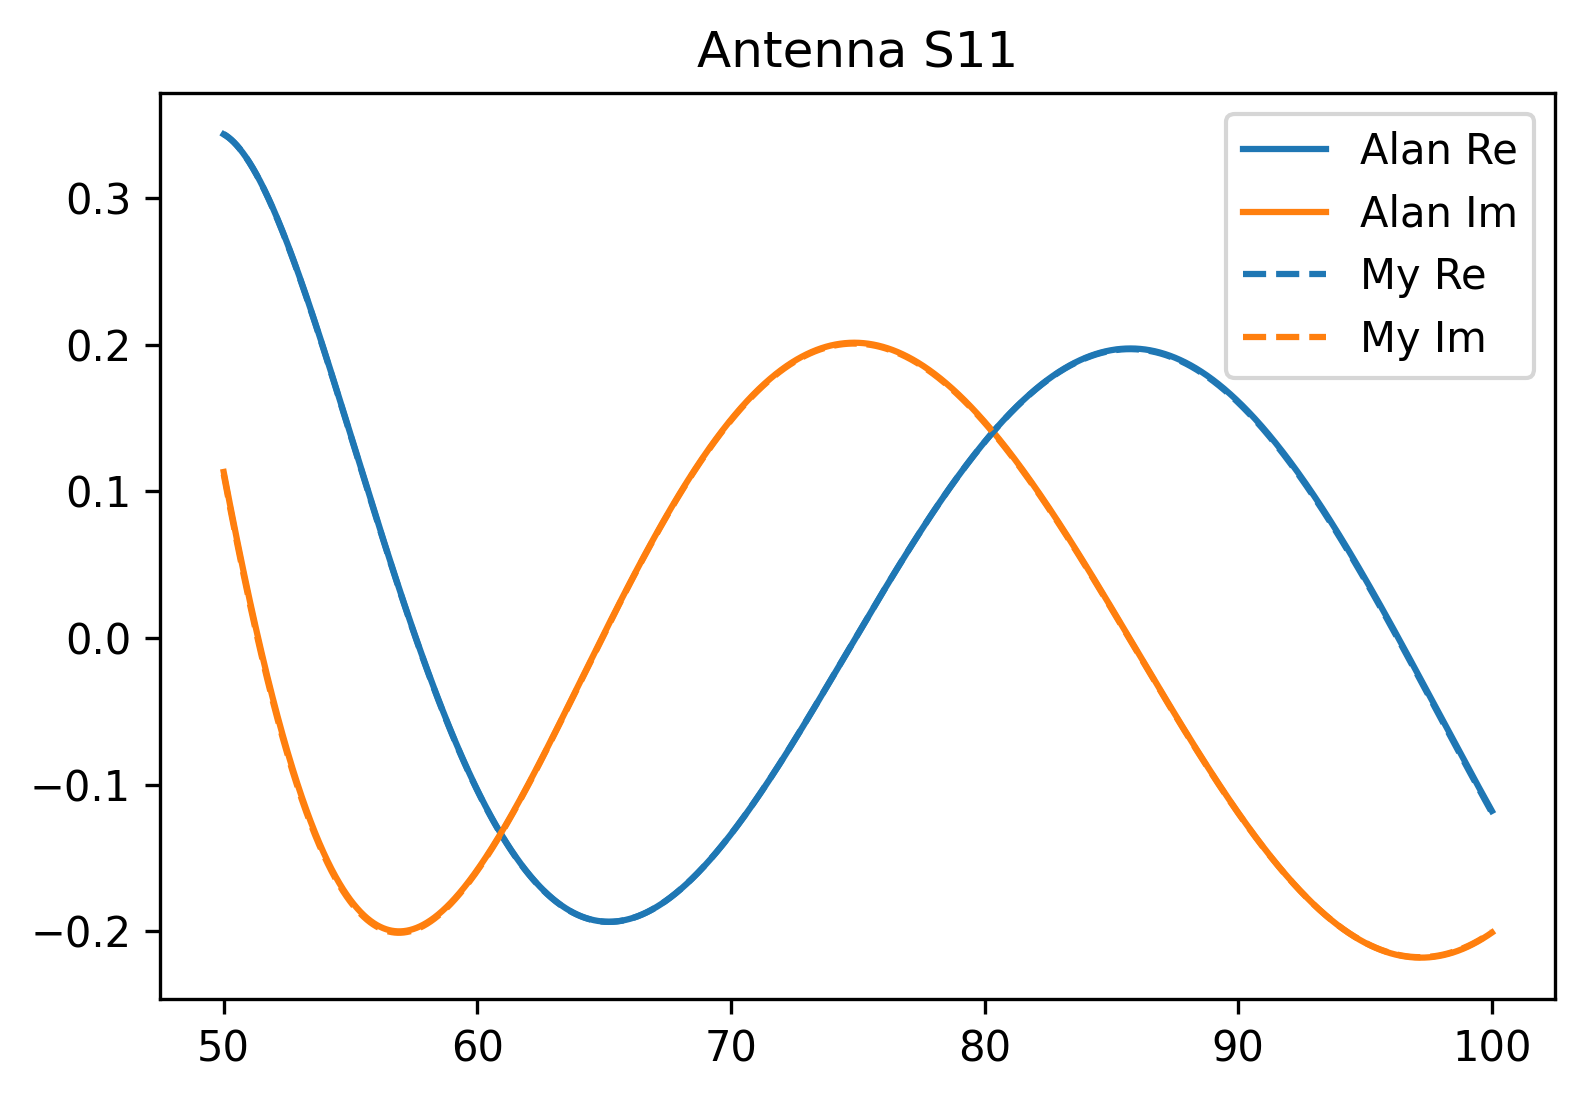

In [11]:
plt.plot(f, np.real(alan_ant_s11), color='C0', label='Alan Re')
plt.plot(f, np.imag(alan_ant_s11), color='C1', label='Alan Im')
plt.plot(f, np.real(labcal.antenna_s11_model(f)), ls='--', color='C0', label='My Re')
plt.plot(f, np.imag(labcal.antenna_s11_model(f)), ls='--', color='C1', label='My Im')
plt.legend()
plt.title("Antenna S11")

Text(0.5, 1.0, 'Antenna S11 Phase')

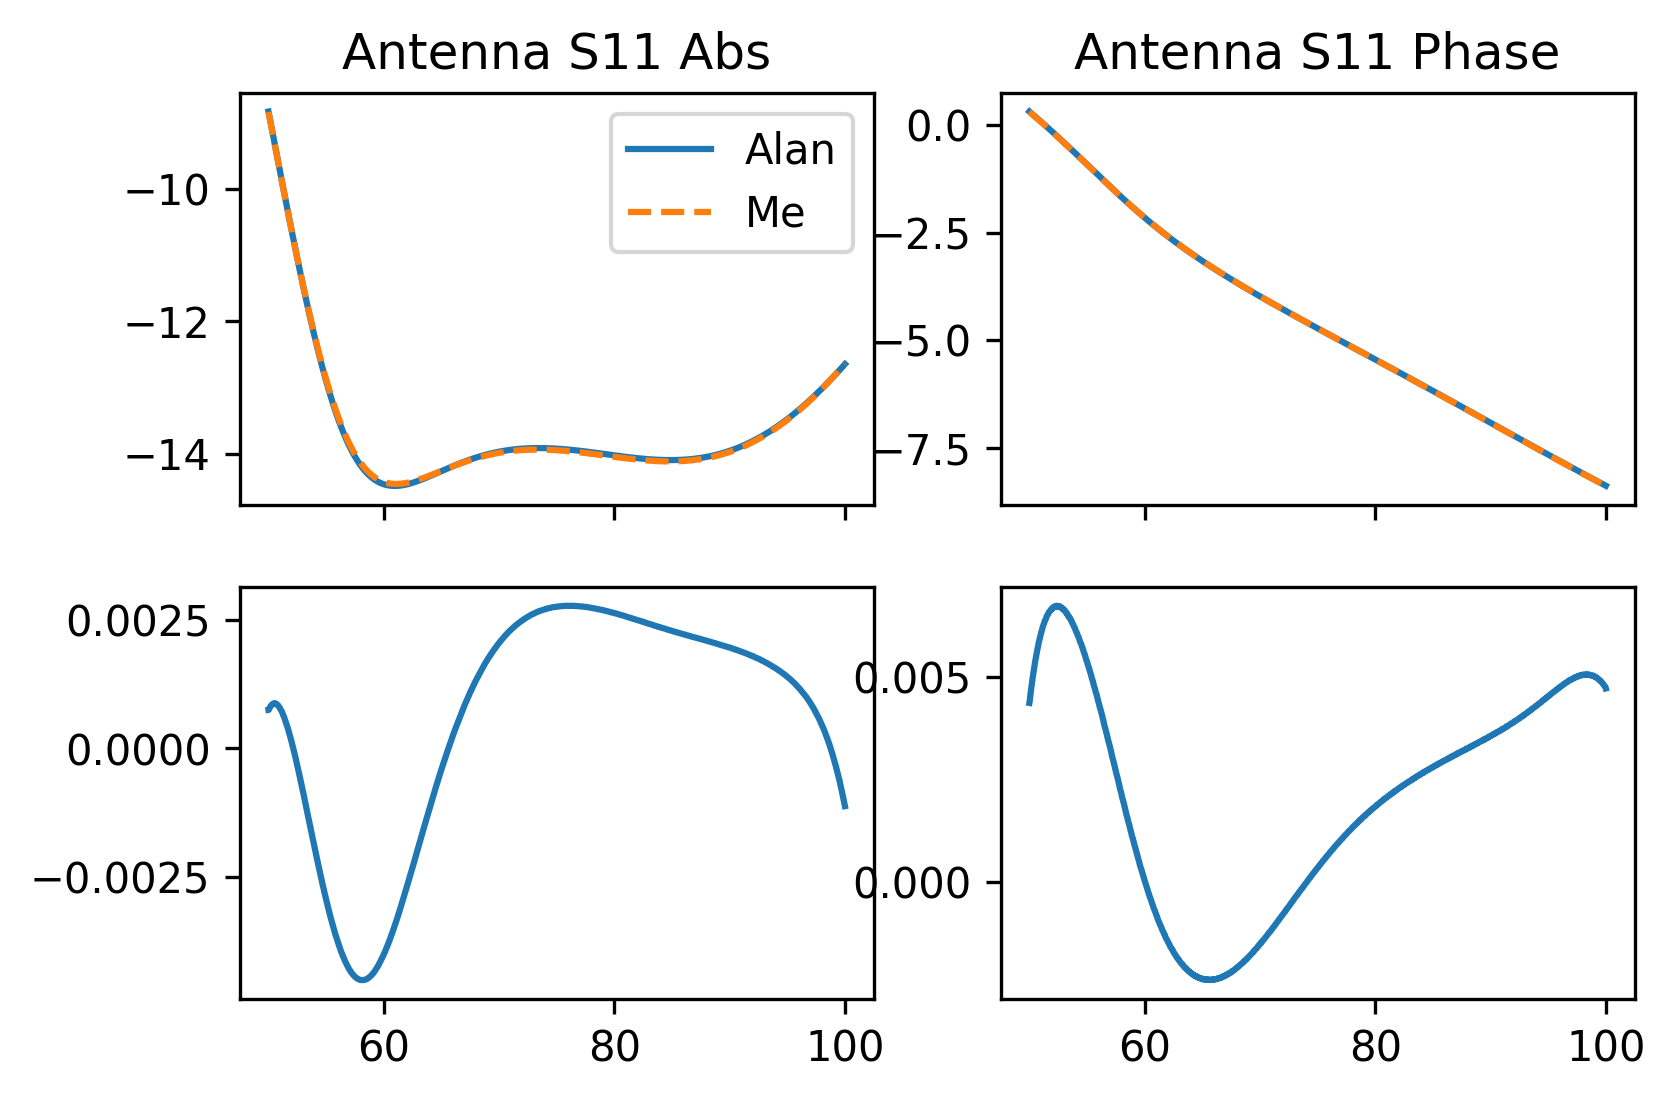

In [12]:
fig, ax = plt.subplots(2, 2, sharex=True)

ax[0, 0].plot(f, 20*np.log10(np.abs(alan_ant_s11)),  label='Alan')
ax[0, 1].plot(f, np.unwrap(np.angle(alan_ant_s11)), )

ax[1, 0].plot(f, np.abs(alan_ant_s11)/np.abs(labcal.antenna_s11_model(f)) - 1)

ax[0, 0].plot(f, 20*np.log10(np.abs(labcal.antenna_s11_model(f))), ls='--',  label='Me')
ax[0, 1].plot(f, np.unwrap(np.angle(labcal.antenna_s11_model(f))), ls='--', )
ax[1, 1].plot(f, np.unwrap(np.angle(alan_ant_s11)) - np.unwrap(np.angle(labcal.antenna_s11_model(f))))

ax[0, 0].legend()
ax[0, 0].set_title("Antenna S11 Abs")
ax[0, 1].set_title("Antenna S11 Phase")

## Compare Calibration Solutions on Sky Data

In [16]:
def decalibrate(t_sky, f_sky, labcal=None):
    if labcal is None:
        ra, rb = rcf.get_linear_coefficients(
            gamma_ant = alan_ant_s11,
            gamma_rec = alan_lna,
            sca = alan_cal['scale'],
            off = alan_cal['offset'],
            t_unc = alan_cal['tunc'],
            t_cos = alan_cal['tcos'],
            t_sin = alan_cal['tsin'],
            t_load=300
        ) 
        tload = 300
        tloadns = 1000
    else:
        ra, rb = labcal.get_linear_coefficients()
        tload = labcal.calobs.t_load
        tloadns = labcal.calobs.t_load_ns
        
    ra = spline(f, ra)(f_sky)
    rb = spline(f, rb)(f_sky)
    
    return ((loss/bmcorr)*t_sky + loss_temp - rb - ra*tload)/(tloadns*ra), ra, rb

def recalibrate(labcal, t_sky, f_sky, with_same=False):
    q, ra, rb = decalibrate(t_sky, f_sky, labcal=labcal if with_same else None)

    if with_same:
        a, b = ra, rb
    else:
        a, b = labcal.get_linear_coefficients()
        a = spline(f, a)(f_sky)
        b = spline(f, b)(f_sky)
    new_t = (labcal.calobs.t_load_ns*a*q + a*labcal.calobs.t_load + b - loss_temp)*bmcorr/loss
    return new_t

antsim = calobs.new_load('AntSim1', calio,  reflection_kwargs={"n_terms": 105})

def plot_coefficient_comparison(labcals, with_total_effects=True, t_sky=None, f_sky=None):

    fig, ax = plt.subplots(6 if with_total_effects else 5, 4 if with_total_effects else 2, sharex=True, figsize=(nutl.single_width*5, 10)) 
    ax[0, 0].plot(f, alan_cal['scale'], label='alan', color='k')
    ax[1, 0].plot(f, alan_cal['offset'], color='k')
    ax[2, 0].plot(f, alan_cal['tunc'], color='k')
    ax[3, 0].plot(f, alan_cal['tcos'], color='k')
    ax[4, 0].plot(f, alan_cal['tsin'], color='k')
    
    for j, (name, labcal) in enumerate(labcals.items()):
        clb=labcal.calobs
        ls=['-','--','-.',':'][j%4]
        
        ax[0, 0].plot(calobs.freq.freq, clb.C1(), label=name, ls=ls)    
        ax[0, 1].plot(calobs.freq.freq, clb.C1()/alan_cal['scale'] -1, ls=ls)
        ax[0, 0].set_ylabel("C1")

        ax[1, 0].plot(calobs.freq.freq, clb.C2(), ls=ls)
        ax[1, 1].plot(calobs.freq.freq, clb.C2()/alan_cal['offset'] -1, ls=ls)
        ax[1, 0].set_ylabel("C2")

        ax[2, 0].plot(calobs.freq.freq, clb.Tunc(), ls=ls)
        ax[2, 1].plot(calobs.freq.freq, clb.Tunc()/alan_cal['tunc'] -1, ls=ls)
        ax[2, 0].set_ylabel("Tunc")

        ax[3, 0].plot(calobs.freq.freq, clb.Tcos(), ls=ls)
        ax[3, 1].plot(calobs.freq.freq, clb.Tcos()/alan_cal['tcos'] -1, ls=ls)
        ax[3, 0].set_ylabel("Tcos")

        ax[4, 0].plot(calobs.freq.freq, clb.Tsin(), ls=ls)
        ax[4, 1].plot(calobs.freq.freq, clb.Tsin()/alan_cal['tsin'] -1, ls=ls)
        ax[4, 0].set_ylabel("Tsin")

        if with_total_effects:            
            for i, (src_name, source) in enumerate(list(calobs.loads.items()) + [('antsim', antsim)]):
                a, b = clb._linear_coefficients(clb.freq.freq, source.s11_model(clb.freq.freq.to_value("MHz")))

                ra, rb = rcf.get_linear_coefficients(
                    gamma_ant = source.s11_model(calobs.freq.freq),
                    gamma_rec = alan_lna,
                    sca = alan_cal['scale'],
                    off = alan_cal['offset'],
                    t_unc = alan_cal['tunc'],
                    t_cos = alan_cal['tcos'],
                    t_sin = alan_cal['tsin'],
                    t_load=300
                )
                
                ax[i, 2].plot(calobs.freq.freq, source.spectrum.averaged_spectrum*a + b, ls=ls)
                ax[i, 3].plot(calobs.freq.freq, source.spectrum.averaged_spectrum*(a-ra) + (b-rb), ls=ls)
                ax[i, 2].set_ylabel(f"Cal. {src_name}")
            
            ra, rb = rcf.get_linear_coefficients(
                gamma_ant = alan_ant_s11,
                gamma_rec = alan_lna,
                sca = alan_cal['scale'],
                off = alan_cal['offset'],
                t_unc = alan_cal['tunc'],
                t_cos = alan_cal['tcos'],
                t_sin = alan_cal['tsin'],
                t_load=300
            ) 
            ra = spline(calobs.freq.freq, ra)(f_sky)
            rb = spline(calobs.freq.freq, rb)(f_sky)
                       
            a, b = labcal.get_linear_coefficients(freq=calobs.freq.freq)
            
            a = spline(calobs.freq.freq, a)(f_sky)
            b = spline(calobs.freq.freq, b)(f_sky)
            
            
            ax[5, 2].plot(f_sky, (t_sky-b)/a, ls=ls)
            ax[5, 3].plot(f_sky, t_sky- recalibrate(labcal,t_sky, f_sky), ls=ls)
            ax[5, 2].set_ylabel("Uncal. Field Data")


    
    ax[0,0].set_title("Noise Waves")
    ax[0,1].set_title("Frac. Deviation")
    ax[0,2].set_title("Cal. Spectra")
    ax[0,3].set_title("Frac. Deviation")
    
    
    
    if with_total_effects:
        ax[5, 2].plot(f_sky, (t_sky-rb)/ra)
        
    for i in range(4):
        ax[-1, i].set_xlabel("Freq")
    ax[0, 0].legend()
    plt.tight_layout()

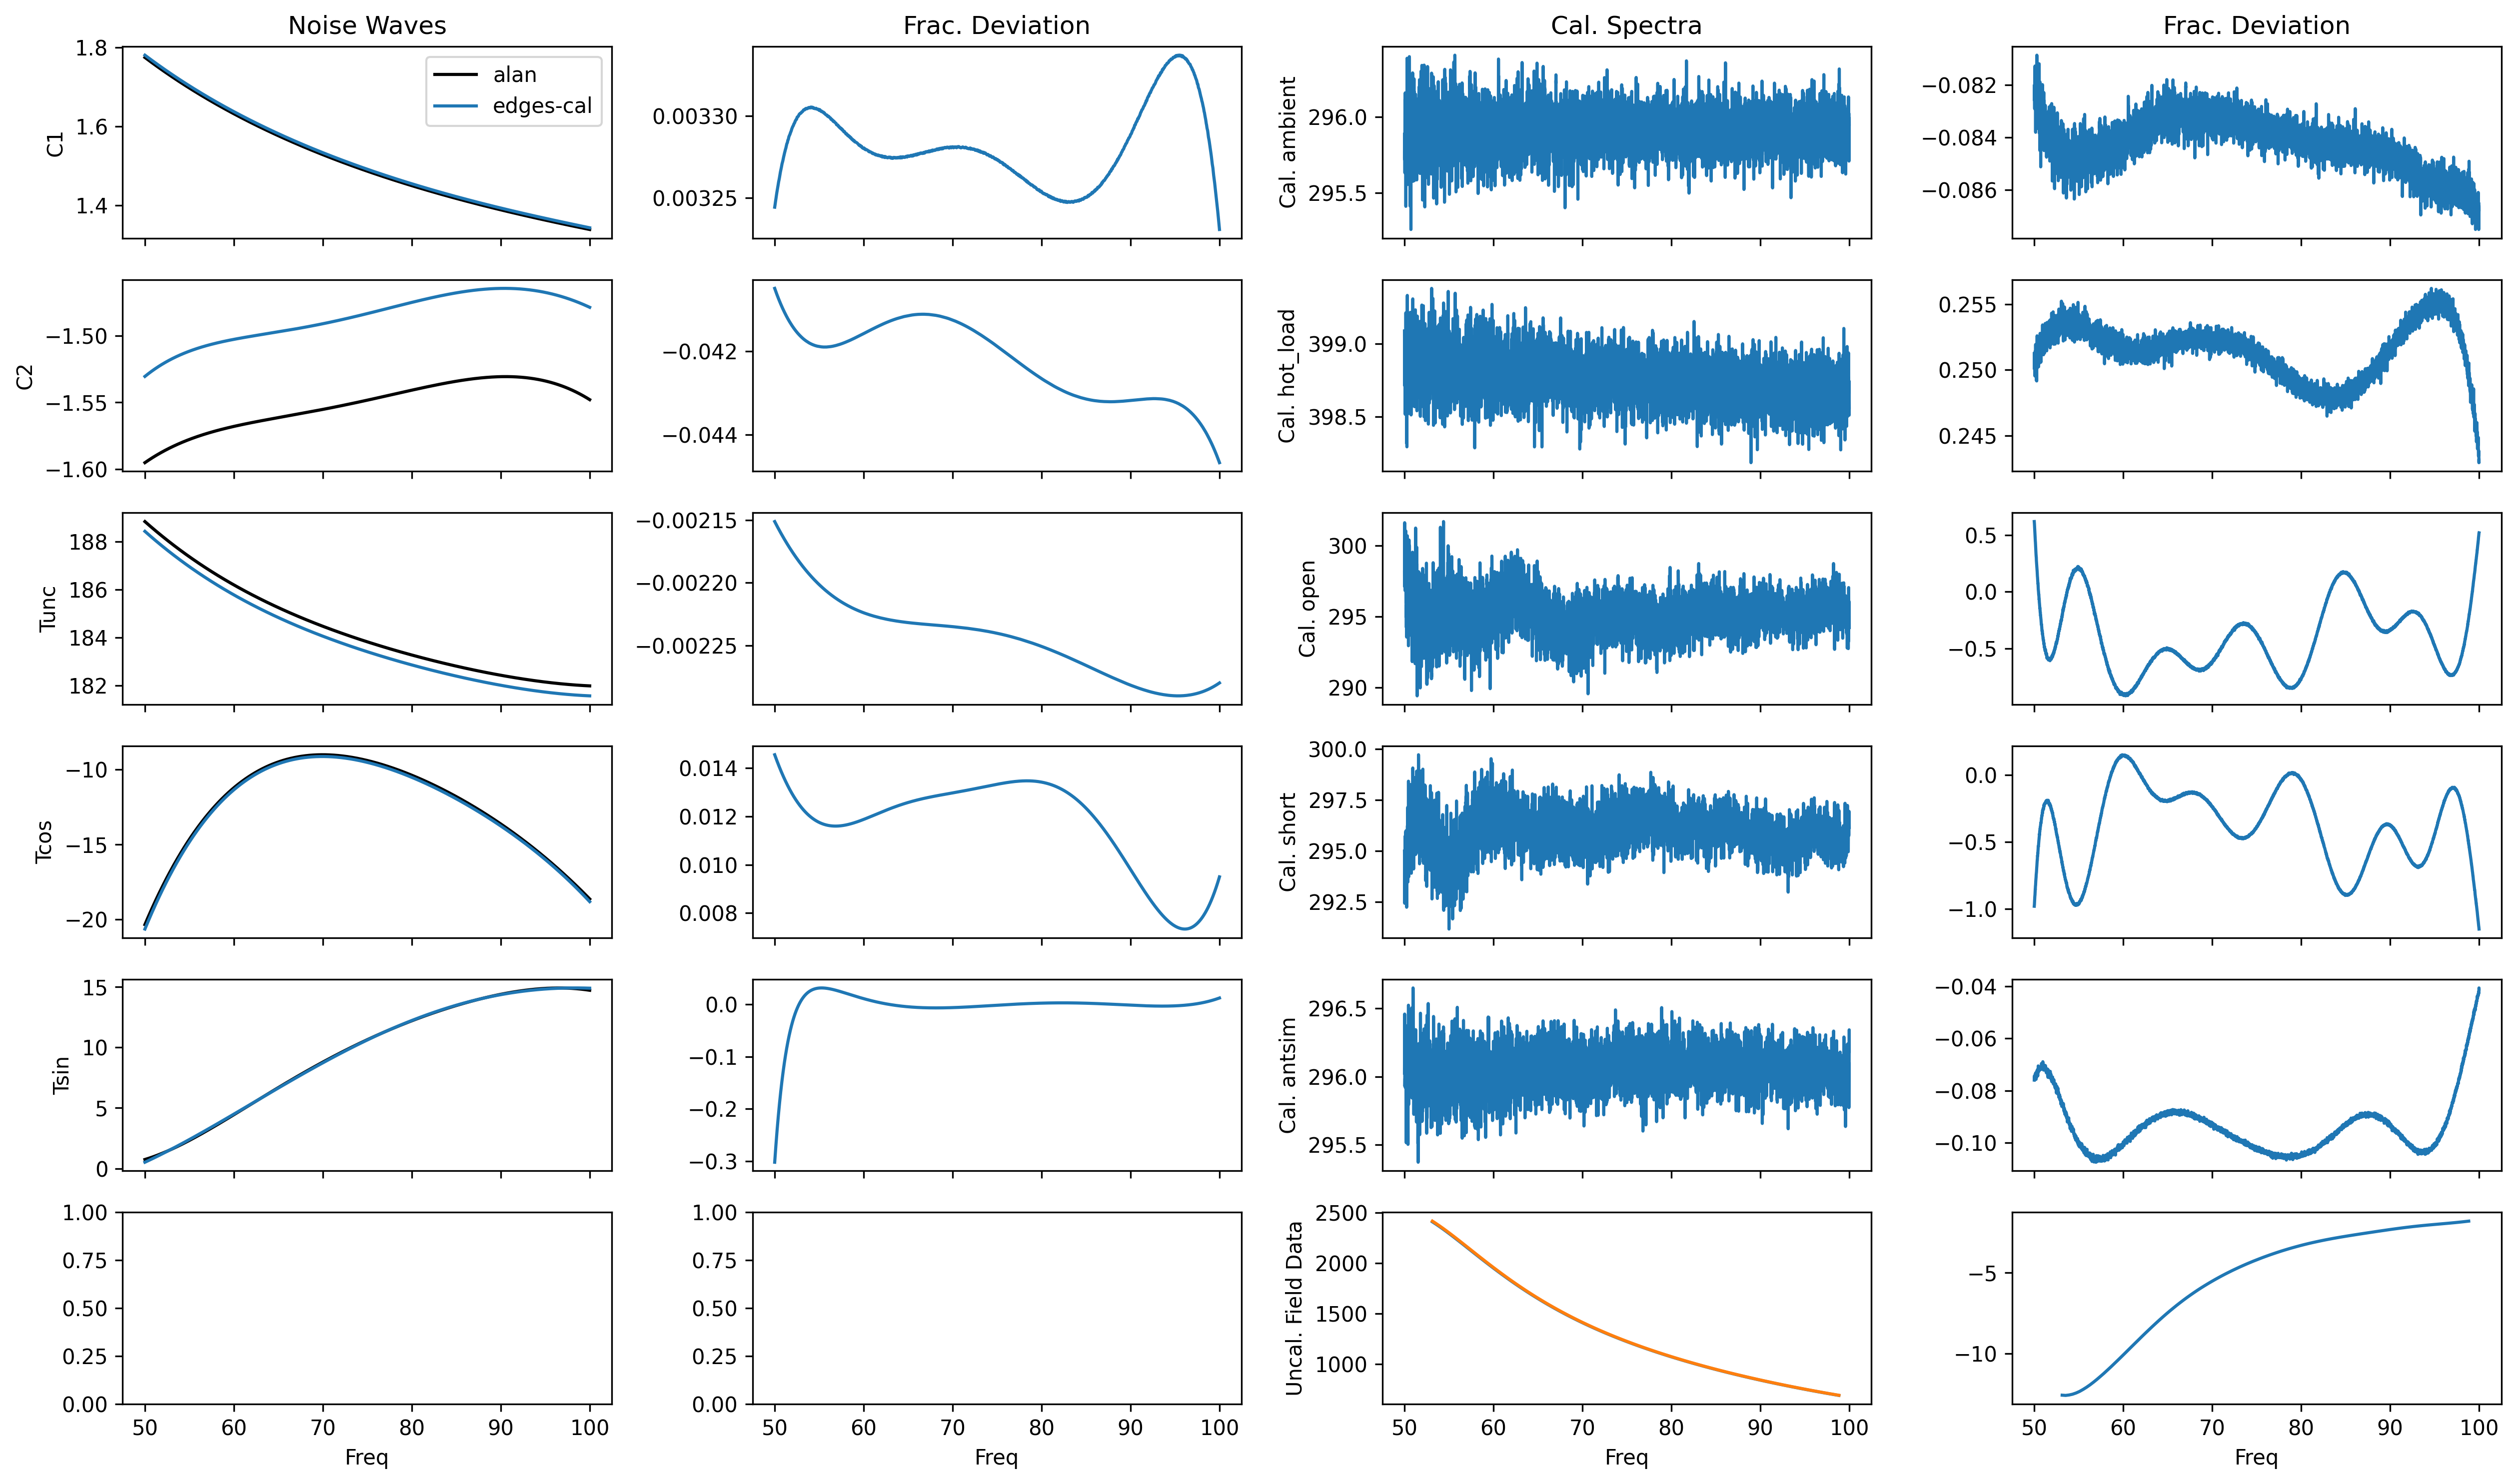

In [17]:
plot_coefficient_comparison({"edges-cal": labcal}, t_sky=alan_sky_data['t_ant'], f_sky=alan_sky_data['freq'])

Here, we see that there are differences in the noise-wave parameters, especially in $C_2$ and $T_{\rm unc}$. These lead to a difference in the final calibrated sky data of more than 10K.

## Injection of Different Quantities

To try and sort out where the main differences come from, we inject Alan's values for different properties into the calibration observation, using them to derived the final calibration coefficients and/or antenna calibration.

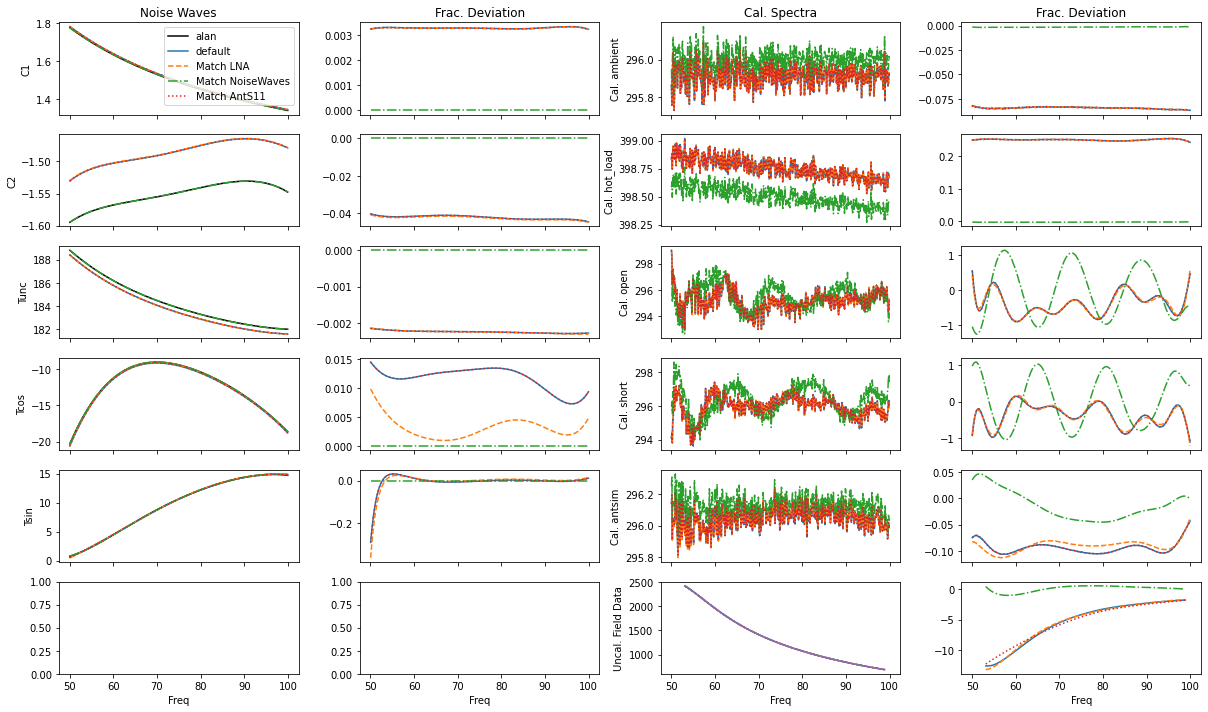

In [70]:
plot_coefficient_comparison(
    {"default": labcal, 
     "Match LNA": utils.get_labcal(calobs.clone(receiver=Receiver(raw_s11=alan_cal['lna_s11'], freq=FrequencyRange(alan_cal['freq']), n_terms=11, model_type='polynomial'))),
     "Match NoiseWaves": utils.get_labcal(
         calobs.to_calibrator().clone(
            C1 = alan_cal_mdl['scale'],
            C2 = alan_cal_mdl['offset'],
            Tunc = alan_cal_mdl['tunc'],
            Tcos = alan_cal_mdl['tcos'],
            Tsin = alan_cal_mdl['tsin'],
        )
     ),
     "Match AntS11": labcal.with_ant_s11(alan_ant_s11_func),
    }, 
    t_sky=alan_sky_data['t_ant'],
    f_sky=alan_sky_data['freq'],
);

Here we see that fixing the LNA S11 does not resolve the biggest differences in the calibration coefficients (second column). We also see that matching the noise-waves directly has the biggest impact on reducing the difference in the final calibrated sky temperature (bottom right), though there is some residual shape due to the antenna S11.

## Summary Differences in Field Data

Let's try to summarize the gross differences induced by our calibration observation. We again inject different properties directly from Alan's results.

### Differences in Calibrated Sky Temperature

In [24]:
recal_tsky = recalibrate(labcal, alan_sky_data['t_ant'], alan_sky_data['freq'])

In [26]:
calobs_lna = calobs.clone(
    receiver=Receiver(
        raw_s11=alan_cal['lna_s11'], 
        freq=FrequencyRange(alan_cal['freq']), 
        n_terms=11, 
        model_type='polynomial'
    )
)

calobs_nw = calobs.to_calibrator().clone(
    C1 = alan_cal_mdl['scale'],
    C2 = alan_cal_mdl['offset'],
    Tunc = alan_cal_mdl['tunc'],
    Tcos = alan_cal_mdl['tcos'],
    Tsin = alan_cal_mdl['tsin'],
)
calobs_nw_lna = calobs_lna.to_calibrator().clone(
    C1 = alan_cal_mdl['scale'],
    C2 = alan_cal_mdl['offset'],
    Tunc = alan_cal_mdl['tunc'],
    Tcos = alan_cal_mdl['tcos'],
    Tsin = alan_cal_mdl['tsin'],
)

labcal_nw = utils.get_labcal(calobs_nw)
labcal_nw_lna = utils.get_labcal(calobs_nw_lna)
labcal_nw_lna_ant = labcal_nw_lna.with_ant_s11(alan_ant_s11_func)
labcal_s11 = labcal.with_ant_s11(alan_ant_s11_func)
labcal_nw_s11 = labcal_nw.with_ant_s11(alan_ant_s11_func)
labcal_lna = utils.get_labcal(calobs_lna)
labcal_lna_s11 = labcal_lna.with_ant_s11(alan_ant_s11_func)


recal_tsky_injected = recalibrate(labcal_nw,  alan_sky_data['t_ant'], alan_sky_data['freq'])
recal_tsky_inj_s11 = recalibrate(labcal_nw_s11,  alan_sky_data['t_ant'], alan_sky_data['freq'])
recal_tsky_s11 = recalibrate(labcal_s11,  alan_sky_data['t_ant'], alan_sky_data['freq'])
recal_tsky_all = recalibrate(labcal_nw_lna_ant,  alan_sky_data['t_ant'], alan_sky_data['freq'])
recal_tsky_lna = recalibrate(labcal_nw_lna, alan_sky_data['t_ant'], alan_sky_data['freq'])
recal_tsky_lna_s11 = recalibrate(labcal_lna_s11, alan_sky_data['t_ant'], alan_sky_data['freq'])


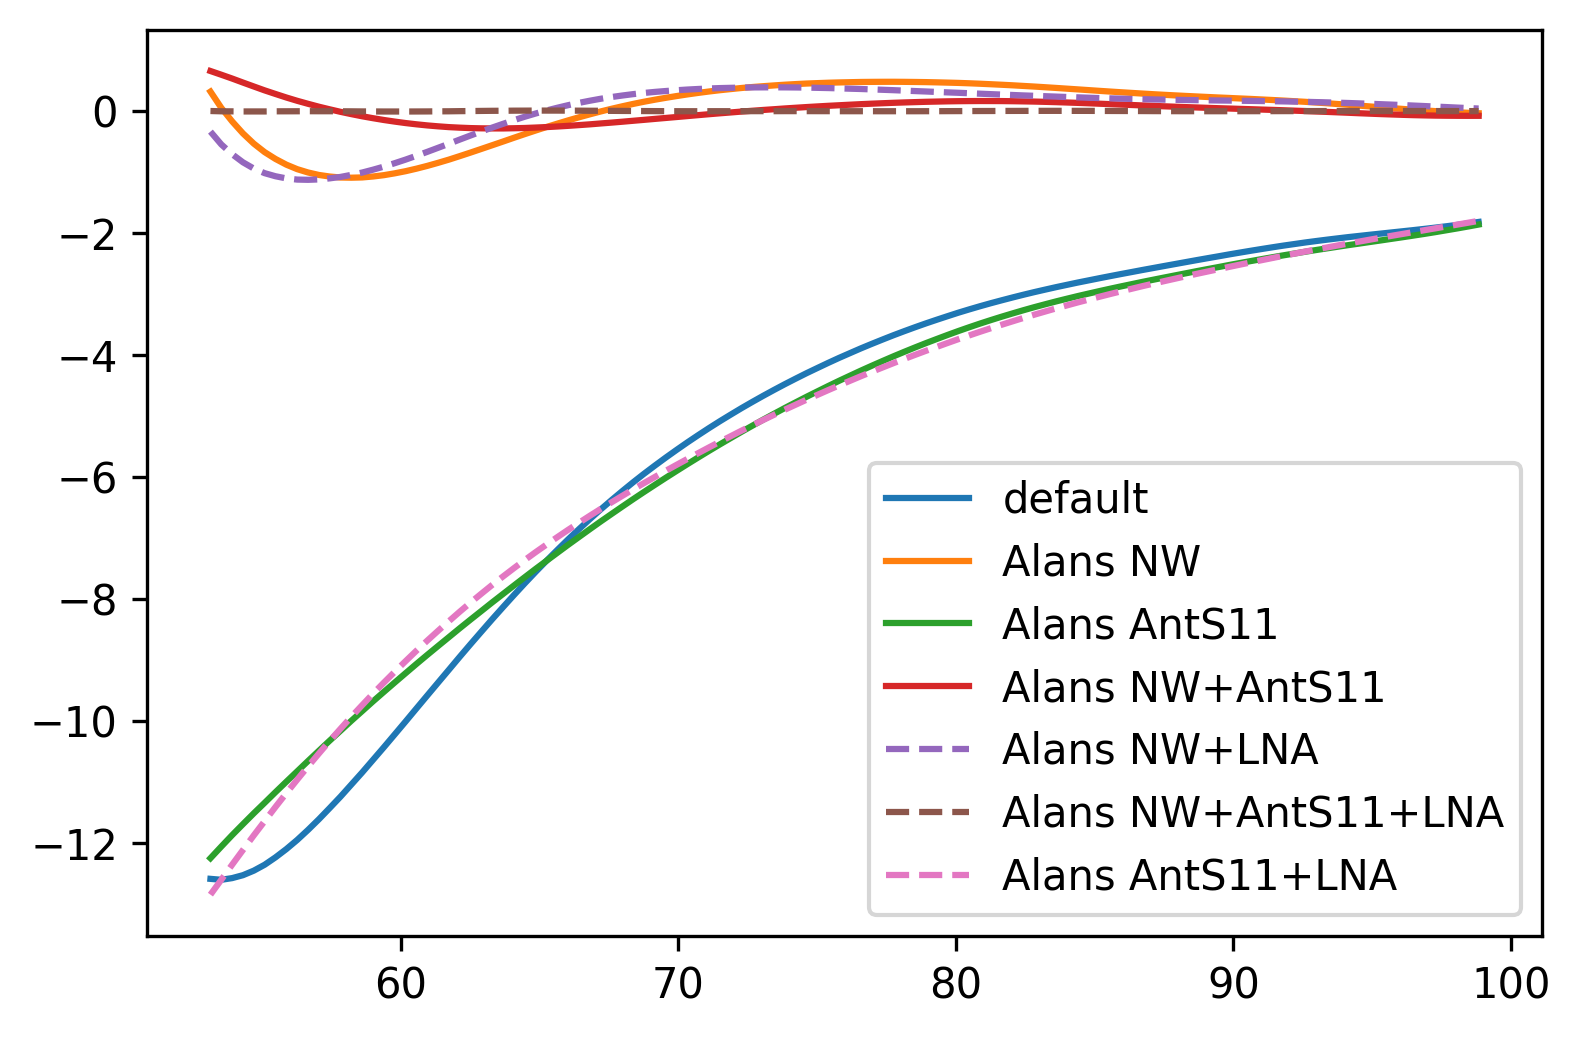

In [27]:
plt.plot(alan_sky_data['freq'], alan_sky_data['t_ant'] - recal_tsky, label='default')
plt.plot(alan_sky_data['freq'], alan_sky_data['t_ant'] - recal_tsky_injected, label='Alans NW')
plt.plot(alan_sky_data['freq'], alan_sky_data['t_ant'] - recal_tsky_s11, label='Alans AntS11')
plt.plot(alan_sky_data['freq'], alan_sky_data['t_ant'] - recal_tsky_inj_s11, label='Alans NW+AntS11')
plt.plot(alan_sky_data['freq'], alan_sky_data['t_ant'] - recal_tsky_lna, label='Alans NW+LNA', ls='--')
plt.plot(alan_sky_data['freq'], alan_sky_data['t_ant'] - recal_tsky_all, label='Alans NW+AntS11+LNA', ls='--')
plt.plot(alan_sky_data['freq'], alan_sky_data['t_ant'] - recal_tsky_lna_s11, label='Alans AntS11+LNA', ls='--')

plt.legend()

### Differences in Foreground Residuals

Even though there are differences, do they really affect final estimates of the absorption feature? Maybe they would be picked up by the LinLog?

In [28]:
def make_absorption(freq, fix=tuple()):
    params={
        'A': {'max':2, 'min': 0.05, 'fiducial': 0.5}, 
        'nu0': {'min': 60, 'max': 90, 'fiducial': 78.5}, 
        'tau': {'min': 1, 'max': 20, 'fiducial': 7}, 
        'w': {'min':1, 'max': 25, 'fiducial': 15}
    }
    
    fid = {}
    for p in fix:
        fid[p] = params.pop(p)['fiducial']
        
    return AbsorptionProfile(
        name='absorption',
        fiducial=fid,
        params=params,
        freqs=freq
    )

In [29]:
linlog5 = mdl.LinLog(n_terms=5)

In [30]:
lfg = LinearFG(
    freq=alan_sky_data['freq'],
    t_sky=recal_tsky,
    var=0.009*np.ones_like(alan_sky_data['freq']),
    fg=linlog5,
    eor=make_absorption(alan_sky_data['freq'], fix=('tau',))
)
res_lfg = run_map(lfg.partial_linear_model)

     Alan's Cal [0. 0. 0.]
          Recal [-0.10813837 -0.25028223  0.01543808]
             NW [-0.08807485 -0.47486677  0.24611516]
         NW+Ant [ 0.16018962 -0.33610628 -0.3711593 ]
            Ant [ 0.14370435 -0.12828523 -0.5550495 ]
         NW+LNA [-0.255788   -0.08895854  1.13404466]
     NW+LNA+Ant [-0.00721923  0.00013728 -0.00914191]
        LNA+Ant [-0.01280992  0.23997167 -0.35849084]


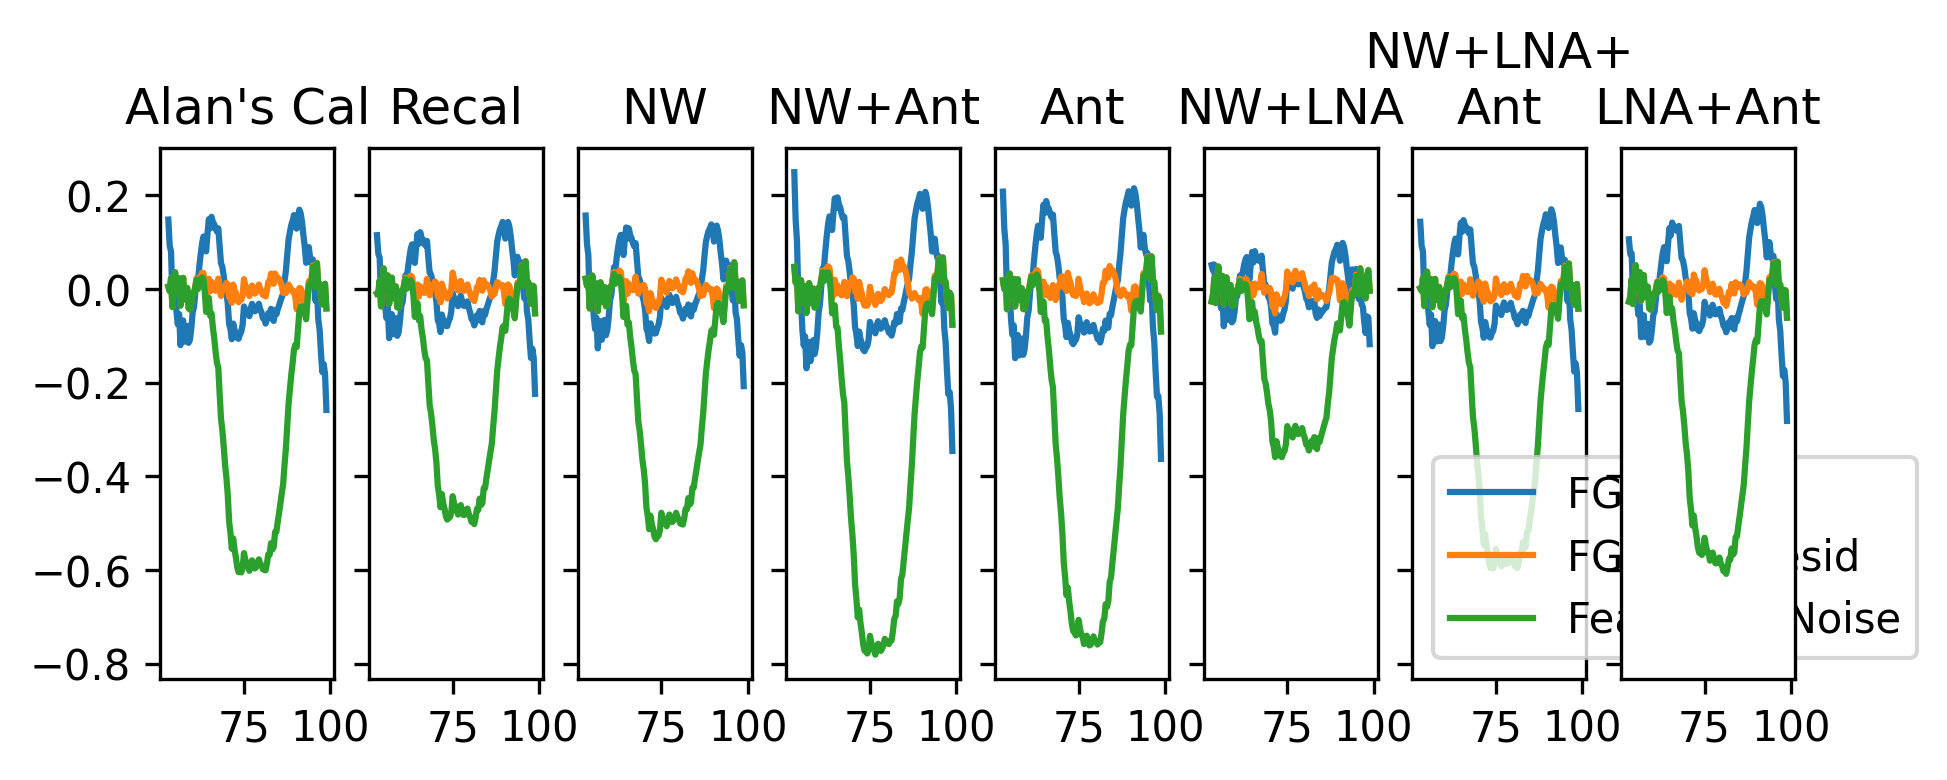

In [39]:
fig, ax = plt.subplots(1, 8, sharey=True, figsize=(nutl.double_width, nutl.double_width/3))

ff = alan_sky_data['freq']

for i, spec in enumerate([alan_sky_data['t_ant'], recal_tsky, recal_tsky_injected, recal_tsky_inj_s11,recal_tsky_s11, recal_tsky_lna, recal_tsky_all, recal_tsky_lna_s11]):
    slf = SemiLinearFit(
        fg=linlog5.at(x=alan_sky_data['freq']), 
        eor=make_absorption(alan_sky_data['freq'], fix=('tau',)), 
        spectrum=spec, 
        sigma=0.03
    )
    res = slf()
    if i==0:
        res_fid = res
        
    ax[i].plot(ff, slf.get_resid([0, 75, 20]), label="FG Resid")
    ax[i].plot(ff, slf.get_resid(res.x), label="FG+Abs Resid")
    ax[i].plot(ff, slf.get_eor(res.x) + slf.get_resid(res.x), label="Feature + Noise")
    
    if i==6:
        ax[i].legend()
    
    title = [
        "Alan's Cal",
        "Recal",
        "NW",
        "NW+Ant",
        "Ant",
        "NW+LNA",
        "NW+LNA+\nAnt",
        "LNA+Ant"
    ][i]
    ax[i].set_title(title)
    print(title.replace("\n", '').rjust(15), res.x - res_fid.x)
    

The overall point here is that the feature itself is not affected that much by our differences in calibration (first and second panel). However, fixing the antenna S11 (right panel) does do the most in bringing it back into line.

## Paper Pre-Calibration Plots

In this section, we make plots specifically for the paper to show the difference in calibration just by changing codes.

In [40]:
def plot_coefficient_comparison_basic(labcal, with_total_effects=True, t_sky=None, f_sky=None):

    fig, ax = plt.subplots(6 if with_total_effects else 5, 4 if with_total_effects else 2, sharex=True, figsize=(single_width*5, 10)) 
    ax[0, 0].plot(f, alan_cal['scale'], label='alan', color='k')
    ax[1, 0].plot(f, alan_cal['offset'], color='k')
    ax[2, 0].plot(f, alan_cal['tunc'], color='k')
    ax[3, 0].plot(f, alan_cal['tcos'], color='k')
    ax[4, 0].plot(f, alan_cal['tsin'], color='k')
    
    
    calobs=labcal.calobs

    ax[0, 0].plot(calobs.freq.freq, calobs.C1()/alan_cal['scale'] -1, ls=ls)
    ax[0, 0].set_ylabel(r"$\Delta T_{\rm L}$")

    ax[1, 0].plot(calobs.freq.freq, calobs.C2()/alan_cal['offset'] -1, ls=ls)
    ax[1, 0].set_ylabel(r"$\Delta T_{\rm LNS}$")

    ax[2, 0].plot(calobs.freq.freq, calobs.Tunc()/alan_cal['tunc'] -1, ls=ls)
    ax[2, 0].set_ylabel(r"$\Delta T_{\rm unc}$")

    ax[0, 1].plot(calobs.freq.freq, calobs.Tcos()/alan_cal['tcos'] -1, ls=ls)
    ax[0, 1].set_ylabel(r"$\Delta T_{\rm cos}$")

    ax[1, 1].plot(calobs.freq.freq, calobs.Tsin()/alan_cal['tsin'] -1, ls=ls)
    ax[1, 1].set_ylabel(r"$\Delta T_{\rm sin}$")

    if with_total_effects:
#            antsim = calobs.new_load('AntSim1', reflection_kwargs={"n_terms": 105})

#             for i, (src_name, source) in enumerate(list(calobs._loads.items()) + [('antsim', antsim)]):
#                 a, b = calobs.get_linear_coefficients(load=source)

#                 ra, rb = rcf.get_linear_coefficients(
#                     gamma_ant = source.s11_model(calobs.freq.freq),
#                     gamma_rec = alan_lna,
#                     sca = alan_cal['scale'],
#                     off = alan_cal['offset'],
#                     t_unc = alan_cal['tunc'],
#                     t_cos = alan_cal['tcos'],
#                     t_sin = alan_cal['tsin'],
#                     t_load=300
#                 )

#                 ax[i, 2].plot(calobs.freq.freq, source.spectrum.averaged_spectrum*a + b, ls=ls)
#                 ax[i, 3].plot(calobs.freq.freq, source.spectrum.averaged_spectrum*(a-ra) + (b-rb), ls=ls)
#                 ax[i, 2].set_ylabel(f"Cal. {src_name}")

        ra, rb = rcf.get_linear_coefficients(
            gamma_ant = alan_ant_s11,
            gamma_rec = alan_lna,
            sca = alan_cal['scale'],
            off = alan_cal['offset'],
            t_unc = alan_cal['tunc'],
            t_cos = alan_cal['tcos'],
            t_sin = alan_cal['tsin'],
            t_load=300
        ) 
        ra = spline(calobs.freq.freq, ra)(f_sky)
        rb = spline(calobs.freq.freq, rb)(f_sky)

        a, b = labcal.get_linear_coefficients(freq=calobs.freq.freq)

        a = spline(calobs.freq.freq, a)(f_sky)
        b = spline(calobs.freq.freq, b)(f_sky)

        ax[1, 2].plot(f_sky, t_sky- recalibrate(labcal,t_sky, f_sky), ls=ls)
        ax[1, 2].set_ylabel(r"$\Delta T_{\rm sky}$")


    
#     ax[0,0].set_title("Noise Waves")
#     ax[0,1].set_title("Frac. Deviation")
#     ax[0,2].set_title("Cal. Spectra")
#     ax[0,3].set_title("Frac. Deviation")
    
    
    
#    if with_total_effects:
#        ax[5, 2].plot(f_sky, (t_sky-rb)/ra)
        
    for i in range(2):
        ax[-1, i].set_xlabel("Freq")
    ax[0, 0].legend()
    plt.tight_layout()

In [41]:
plot_coefficient_comparison_basic()

TypeError: plot_coefficient_comparison_basic() missing 1 required positional argument: 'labcal'